# Experiment Notebook

In [966]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm

from src.fts_src import FinancialTimeSeriesSparseModel
from src.metrics import rmsre
from src.mesax import meSAX
from src.data_generator import download_data

# global matplotlib settings fontsize
plt.rcParams.update({'font.size': 14})

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load and split data

In [884]:
START_DATE = '2010-01-01'
END_DATE = '2020-01-01'
TRAIN_PROPORTION = 0.8

In [885]:
prices = download_data(START_DATE, END_DATE).dropna()
train_price, test_price = train_test_split(prices, train_size=TRAIN_PROPORTION, test_size=1-TRAIN_PROPORTION, shuffle=False)

log_return = np.log(prices).diff().dropna() * 1e4 # put in bps
train_log_return, test_log_return = train_test_split(log_return, train_size=TRAIN_PROPORTION, test_size=1-TRAIN_PROPORTION, shuffle=False)

## Overview of the data

In [886]:
TEST_ASSET_NAME = 'CAC 40'

Prices

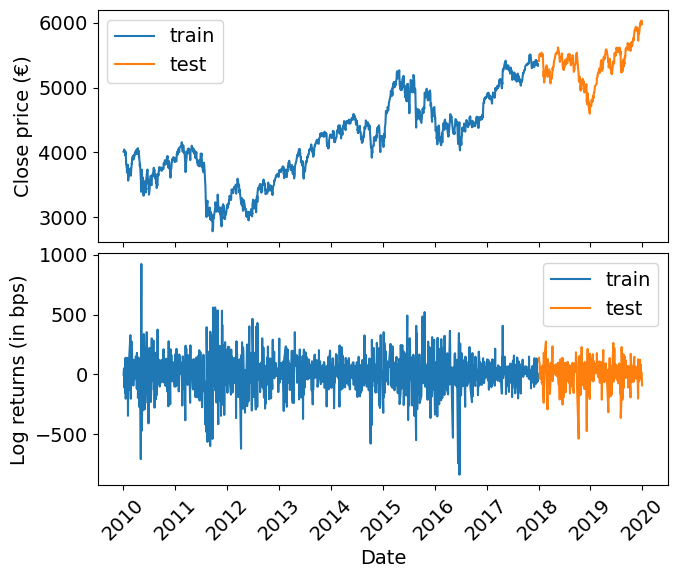

In [624]:
# train test split

plt.figure(figsize=(7, 6))
# plot the train and test data
plt.subplot(2, 1, 1)
plt.plot(train_price[TEST_ASSET_NAME], label='train')
plt.plot(test_price[TEST_ASSET_NAME], label='test')
plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Close price (€)')

plt.subplot(2, 1, 2)
plt.plot(train_log_return[TEST_ASSET_NAME], label='train')
plt.plot(test_log_return[TEST_ASSET_NAME], label='test')

plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Log returns (in bps)')

plt.tight_layout()
# share x axis
plt.subplots_adjust(hspace=0.05)
plt.savefig('train_test_data.pdf')
plt.show()

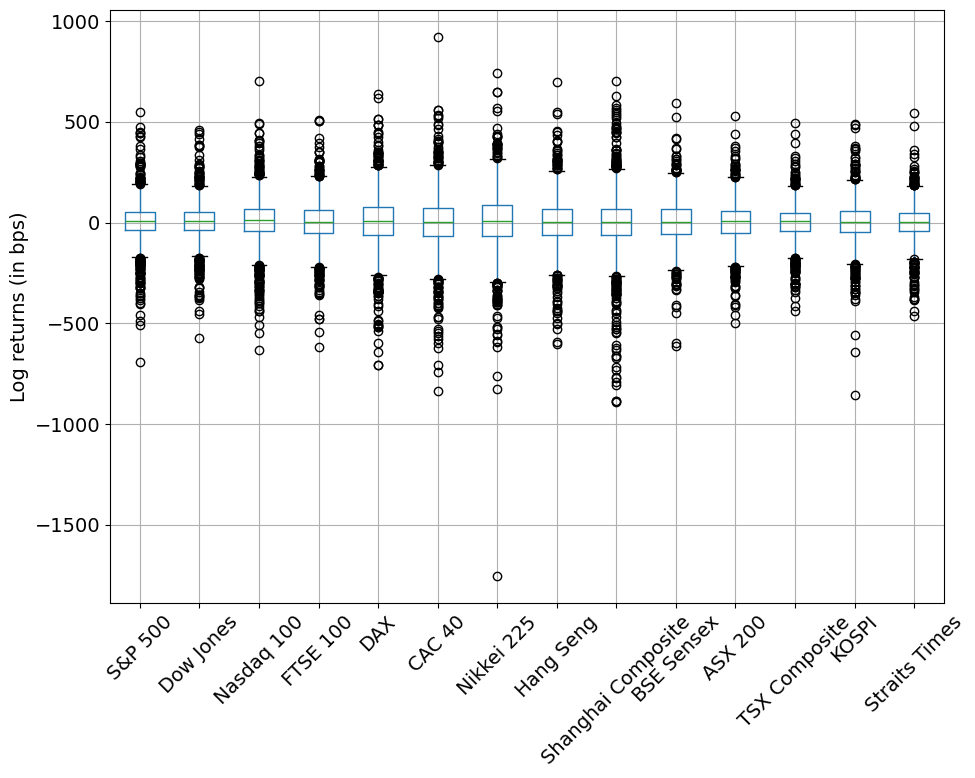

In [625]:
# boxplot of the log returns
plt.figure(figsize=(10, 8))
train_log_return.boxplot()
plt.xticks(rotation=45)
plt.ylabel('Log returns (in bps)')
plt.tight_layout()

In [617]:
# get the average, annualized volatility , skewness of the log returns
mean = train_log_return.mean()
std = train_log_return.std() * np.sqrt(252)
skew = train_log_return.skew()
kurtosis = train_log_return.kurtosis()
print(pd.concat([mean, std, skew, kurtosis], axis=1, keys=['mean', 'std', 'skew', 'kurtosis']).round(2).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  mean &      std &  skew &  kurtosis \\
\midrule
S\&P 500            &  5.60 &  1647.70 & -0.35 &      4.84 \\
Dow Jones          &  5.53 &  1533.01 & -0.28 &      4.02 \\
Nasdaq 100         &  7.96 &  1893.43 & -0.29 &      3.36 \\
FTSE 100           &  2.12 &  1717.30 & -0.20 &      3.25 \\
DAX                &  4.95 &  2220.26 & -0.29 &      2.97 \\
CAC 40             &  1.85 &  2304.17 & -0.26 &      4.08 \\
Nikkei 225         &  4.93 &  2462.38 & -1.14 &     12.75 \\
Hang Seng          &  2.03 &  1996.44 & -0.13 &      2.83 \\
Shanghai Composite &  0.10 &  2534.12 & -0.77 &      5.59 \\
BSE Sensex         &  4.26 &  1754.11 & -0.10 &      2.53 \\
ASX 200            &  1.44 &  1618.57 & -0.19 &      2.35 \\
TSX Composite      &  2.03 &  1414.85 & -0.33 &      3.25 \\
KOSPI              &  2.43 &  1676.09 & -0.55 &      5.70 \\
Straits Times      &  1.04 &  1428.43 & -0.29 &      3.80 \\
\bottomrule
\end{tabular}



/var/folders/k1/n25_cgpj17b12lgf2qvp_t_h0000gn/T/ipykernel_20347/3105509466.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.concat([mean, std, skew, kurtosis], axis=1, keys=['mean', 'std', 'skew', 'kurtosis']).round(2).to_latex())


## Stationarity test

In [952]:
def adf_test_for_dataframe(df):
    """
    Perform Augmented Dickey-Fuller (ADF) test for each column in a DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame with time series data.
    
    Returns:
    pd.DataFrame: A DataFrame containing the ADF test results for each column, including split critical values.
    """
    results = []

    for column in df.columns:
        series = df[column].dropna()  # Handle missing values by dropping them
        adf_result = adfuller(series)
        
        # Extract critical values and other statistics
        critical_values = adf_result[4]
        
        results.append({
            'Column': column,
            'ADF Statistic': adf_result[0],
            'p-value': adf_result[1],
            'Lags Used': adf_result[2],
            'Number of Observations': adf_result[3],
            'Critical Value (1%)': critical_values['1%'],
            'Critical Value (5%)': critical_values['5%'],
            'Critical Value (10%)': critical_values['10%'],
            'Stationary': adf_result[1] < 0.05  # True if p-value < 0.05
        })

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    return results_df.set_index('Column')

In [956]:
print(adf_test_for_dataframe(log_return).round(2).to_latex())

\begin{tabular}{lrrrrrrrl}
\toprule
{} &  ADF Statistic &  p-value &  Lags Used &  Number of Observations &  Critical Value (1\%) &  Critical Value (5\%) &  Critical Value (10\%) &  Stationary \\
Column             &                &          &            &                         &                      &                      &                       &             \\
\midrule
S\&P 500            &         -22.41 &      0.0 &          4 &                    1923 &                -3.43 &                -2.86 &                 -2.57 &        True \\
Dow Jones          &         -22.27 &      0.0 &          4 &                    1923 &                -3.43 &                -2.86 &                 -2.57 &        True \\
Nasdaq 100         &         -22.16 &      0.0 &          4 &                    1923 &                -3.43 &                -2.86 &                 -2.57 &        True \\
FTSE 100           &         -24.03 &      0.0 &          3 &                    1924 &               

/var/folders/k1/n25_cgpj17b12lgf2qvp_t_h0000gn/T/ipykernel_20347/497221315.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(adf_test_for_dataframe(log_return).round(2).to_latex())


## m-eSAX representation

### Handy manipulation

In [940]:
model = meSAX(
  alphabet_size=64,
  rolling_window_size=60,
  rolling_window_stride=10, 
  paa_window_size=10
)

Compression ratio: 1.1111111111111112
RMSRE: 0.5526412237335043


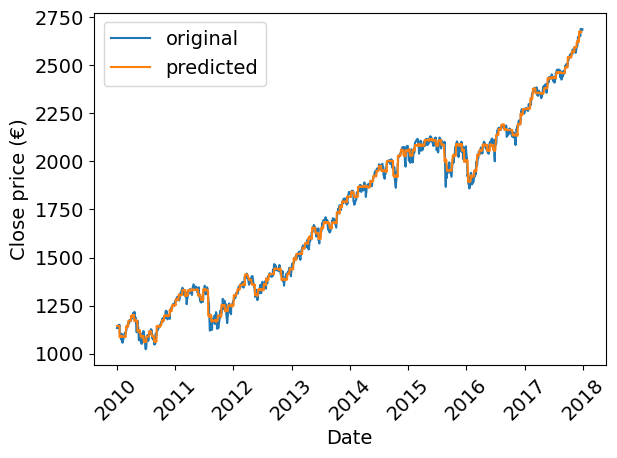

In [957]:
train, test = train_price['S&P 500'], test_price['S&P 500']


train_time_series = train.values.squeeze()
embds, compression_ratio = model.fit_transform(train_time_series, fitting_method='uniform')
train_prediction = model.predict(embds, sampling_method='random')

test_time_series = test.values.squeeze()
embds, compression_ratio = model.transform(test_time_series)
test_prediction = model.predict(embds, sampling_method='random')

print('Compression ratio:', compression_ratio)
print('RMSRE:', rmsre(train_time_series, test_prediction))
plt.plot(train.index, train_time_series, label='original', color='C0')
plt.plot(train.index[:len(train_prediction)], train_prediction, label='predicted', color='C1')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Close price ($)')
plt.legend()
plt.tight_layout()
# plt.savefig('10_alphabet_meSAX_prediction_train.pdf')

Limitation of the fitting due to values that are capped/floored because not on the historical data.

Compression ratio: 1.1111111111111112
RMSRE: 0.5526166981402245


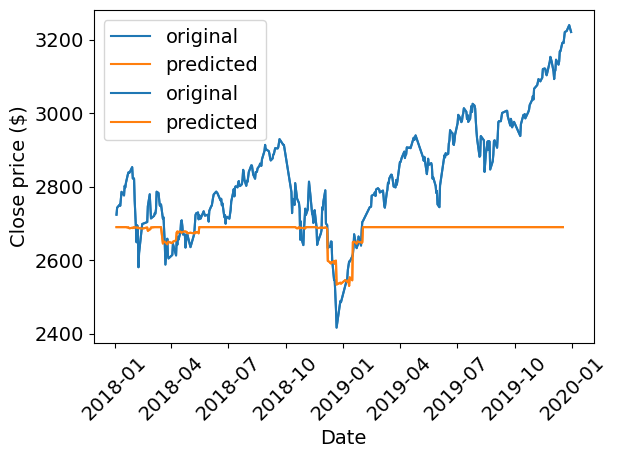

In [962]:
test_time_series = test.values.squeeze()
embds, compression_ratio = model.transform(test_time_series)
test_prediction = model.predict(embds, sampling_method='random')

plt.plot(test.index, test_time_series, color='C0', label='original')
plt.plot(test.index[:len(test_prediction)], test_prediction, color='C1', label='predicted')
print('Compression ratio:', compression_ratio)
print('RMSRE:', rmsre(train_time_series, test_prediction))
plt.plot(test.index,test_time_series, label='original')
plt.plot(test.index[:len(test_prediction)], test_prediction, label='predicted')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Close price ($)')
plt.legend()
plt.tight_layout()
# plt.savefig('10_alphabet_meSAX_prediction_test.pdf')

### Results table

In [824]:
meSAX_default_params_dict = {
  'alphabet_size': 64,
  'rolling_window_size': 60,
  'rolling_window_stride': 10,
  'paa_window_size': 10,
  'fitting_method': 'median',
  'reconstruction_method': 'slope',
}

meSAX_params_dict = {
  'alphabet_size': [32, 64, 128],
  'rolling_window_size': [30, 60, 120],
  'rolling_window_stride': [5, 10, 20],
  'paa_window_size': [5, 10, 20],
  'fitting_method': ['uniform', 'median'],
  'reconstruction_method': ['slope', 'random'],
}


meSAX_results = pd.DataFrame(
  columns=[
      'ticker',
      'dataset_type', 
      'alphabet_size', 
      'rolling_window_size', 
      'rolling_window_stride', 
      'paa_window_size', 
      'fitting_method', 
      'reconstruction_method', 
      'compression_ratio', 
      'price_rmsre', 
  ],
)

# Varing one parameter at a time and keeping the others to default
iterable = tqdm(meSAX_params_dict.items())
for param_name, param_values in iterable:
    for param_value in param_values:
        
        # experiment parameters
        params = meSAX_default_params_dict.copy()
        params[param_name] = param_value

        # load the model
        model = meSAX(
          alphabet_size=params['alphabet_size'],
          rolling_window_size=params['rolling_window_size'],
          rolling_window_stride=params['rolling_window_stride'], 
          paa_window_size=params['paa_window_size'],
        )

        # itterate over dataset indexes
        for stock_index in prices.columns:
            iterable.set_description(f'{param_name}: {param_value} - {stock_index}')  
            train, test = train_price[stock_index], test_price[stock_index]

            # fit transform and predict
            embds, train_compression_ratio = model.fit_transform(train.values.squeeze(), fitting_method=params['fitting_method'])
            prediction = model.predict(embds, sampling_method=params['reconstruction_method'])
            train_price_rmsre = rmsre(train.values.squeeze(), prediction)

            # transform data on the test set
            embds, test_compression_ratio = model.transform(test.values.squeeze())
            prediction = model.predict(embds, sampling_method=params['reconstruction_method'])
            test_price_rmsre = rmsre(test.values.squeeze(), prediction)

            # add the results to the dataframe
            meSAX_results = pd.concat([
                meSAX_results,
                pd.DataFrame(
                    [[
                        stock_index,
                        'train', 
                        params['alphabet_size'], 
                        params['rolling_window_size'], 
                        params['rolling_window_stride'], 
                        params['paa_window_size'], 
                        params['fitting_method'], 
                        params['reconstruction_method'], 
                        train_compression_ratio, 
                        train_price_rmsre
                    ]],
                    columns=meSAX_results.columns
                ),
                pd.DataFrame(
                    [[
                        stock_index,
                        'test', 
                        params['alphabet_size'], 
                        params['rolling_window_size'], 
                        params['rolling_window_stride'], 
                        params['paa_window_size'], 
                        params['fitting_method'], 
                        params['reconstruction_method'], 
                        test_compression_ratio, 
                        test_price_rmsre
                    ]],
                    columns=meSAX_results.columns
                )
            ])

reconstruction_method: random - Straits Times: 100%|██████████| 6/6 [00:02<00:00,  2.66it/s]     


In [825]:
meSAX_results

,ticker,dataset_type,alphabet_size,rolling_window_size,rolling_window_stride,paa_window_size,fitting_method,reconstruction_method,compression_ratio,price_rmsre
0,S&P 500,train,32,60,10,10,median,slope,1.333333,0.023045
0,S&P 500,test,32,60,10,10,median,slope,1.333333,0.074169
0,Dow Jones,train,32,60,10,10,median,slope,1.333333,0.022822
0,Dow Jones,test,32,60,10,10,median,slope,1.333333,0.060898
0,Nasdaq 100,train,32,60,10,10,median,slope,1.333333,0.028860
...,...,...,...,...,...,...,...,...,...,...
0,TSX Composite,test,64,60,10,10,median,random,1.111111,0.018351
0,KOSPI,train,64,60,10,10,median,random,1.111111,0.013881
0,KOSPI,test,64,60,10,10,median,random,1.111111,0.016428
0,Straits Times,train,64,60,10,10,median,random,1.111111,0.012202


In [826]:
df = meSAX_results.sort_values(by=['dataset_type'])
df = df.groupby(['dataset_type', 'alphabet_size', 'rolling_window_size', 'rolling_window_stride', 'paa_window_size', 'fitting_method', 'reconstruction_method']).mean().unstack('dataset_type').swaplevel(axis=1).sort_index(axis=1).reset_index()

# varing one parameter at a time and keeping the others to default
df = df[
  (df['alphabet_size'] == meSAX_default_params_dict['alphabet_size'])
  & (df['rolling_window_size'] == meSAX_default_params_dict['rolling_window_size'])
  # & (df['rolling_window_stride'] == meSAX_default_params_dict['rolling_window_stride'])
  # & (df['paa_window_size'] == meSAX_default_params_dict['paa_window_size'])
  # & (df['fitting_method'] == meSAX_default_params_dict['fitting_method'])
  # & (df['reconstruction_method'] == meSAX_default_params_dict['reconstruction_method'])
]
df

dataset_type alphabet_size rolling_window_size rolling_window_stride  \
                                                                       
2                       64                  60                     5   
3                       64                  60                    10   
4                       64                  60                    10   
5                       64                  60                    10   
6                       64                  60                    10   
7                       64                  60                    10   
8                       64                  60                    20   

dataset_type paa_window_size fitting_method reconstruction_method  \
                                                                    
2                         10         median                 slope   
3                          5         median                 slope   
4                         10         median                random   
5                         10         median                 slope   
6                         10        uniform                 slope   
7                         20         median                 slope   
8                         10         median                 slope   

dataset_type              test                         train              
             compression_ratio price_rmsre compression_ratio price_rmsre  
2                     1.111111    0.043144          1.111111    0.015790  
3                     0.555556    0.043036          0.555556    0.016423  
4                     1.111111    0.042764          1.111111    0.015730  
5                     1.111111    0.045214          1.111111    0.022084  
6                     1.111111    0.044440          1.111111    0.021455  
7                     2.222222    0.047016          2.222222    0.023785  
8                     1.111111    0.045214          1.111111    0.022084

In [827]:
df = meSAX_results.sort_values(by=['dataset_type'])
df = df.groupby(['dataset_type', 'alphabet_size', 'rolling_window_size', 'rolling_window_stride', 'paa_window_size', 'fitting_method', 'reconstruction_method']).mean().unstack('dataset_type').swaplevel(axis=1).sort_index(axis=1).reset_index()

# varing one parameter at a time and keeping the others to default
df = df[
  (df['alphabet_size'] == meSAX_default_params_dict['alphabet_size'])
  & (df['rolling_window_size'] == meSAX_default_params_dict['rolling_window_size'])
  & (df['rolling_window_stride'] == meSAX_default_params_dict['rolling_window_stride'])
  & (df['paa_window_size'] == meSAX_default_params_dict['paa_window_size'])
  & (df['fitting_method'] == meSAX_default_params_dict['fitting_method'])
  # & (df['reconstruction_method'] == meSAX_default_params_dict['reconstruction_method'])
].set_index('reconstruction_method').drop(columns=[
  'alphabet_size', 
  'rolling_window_size', 
  'rolling_window_stride',
    'paa_window_size', 
    'fitting_method', 
    # 'reconstruction_method'
    ]
)
df.columns.names = [None, None]
print(df.to_latex(float_format='%.4f'))

\begin{tabular}{lrrrr}
\toprule
{} & \multicolumn{2}{l}{test} & \multicolumn{2}{l}{train} \\
{} & compression\_ratio & price\_rmsre & compression\_ratio & price\_rmsre \\
reconstruction\_method &                   &             &                   &             \\
\midrule
random                &            1.1111 &      0.0428 &            1.1111 &      0.0157 \\
slope                 &            1.1111 &      0.0452 &            1.1111 &      0.0221 \\
\bottomrule
\end{tabular}



/var/folders/k1/n25_cgpj17b12lgf2qvp_t_h0000gn/T/ipykernel_20347/25882212.py:5: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df = df[
/var/folders/k1/n25_cgpj17b12lgf2qvp_t_h0000gn/T/ipykernel_20347/25882212.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(float_format='%.4f'))


## Finanacial time series sparse representation coding (FT-SRC)

### Handy manipulation

In [933]:
dict_atoms_number = 20
non_zero_coeff = 8
sliding_window_size = 30
sliding_window_stride = 10
max_iter = 100

In [934]:
model = FinancialTimeSeriesSparseModel(
    n_components=dict_atoms_number,
    n_nonzero_coefs=non_zero_coeff,
    window_size=sliding_window_size,
    stride=sliding_window_stride,
    max_iter=max_iter
)

In [935]:
train, test = train_price['S&P 500'], test_price['S&P 500']


train_time_series = train.values.squeeze()
model.fit(train_time_series)

[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................
[*] Transforming the segmented data into sparse codes...


DictionaryLearning(max_iter=100, n_components=20, transform_max_iter=100,
                   transform_n_nonzero_coefs=8, verbose=True)

Compression ratio: 7.5
RMSRE: 0.0063125880477668435


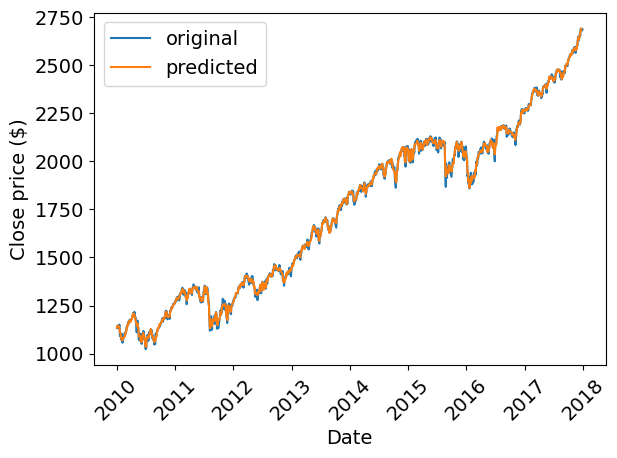

In [931]:
prediction, compression_ratio = model.predict(train_time_series)

print('Compression ratio:', compression_ratio)
print('RMSRE:', rmsre(train_time_series, prediction))

plt.plot(train.index, train_time_series, label='original', color='C0')
plt.plot(train.index, prediction, label='predicted', color='C1')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Close price ($)')
plt.legend()
plt.tight_layout()
plt.savefig('8_sparse_good_FTSRC_prediction_train.pdf')

Compression ratio: 3.75
RMSRE: 0.004519274641517725


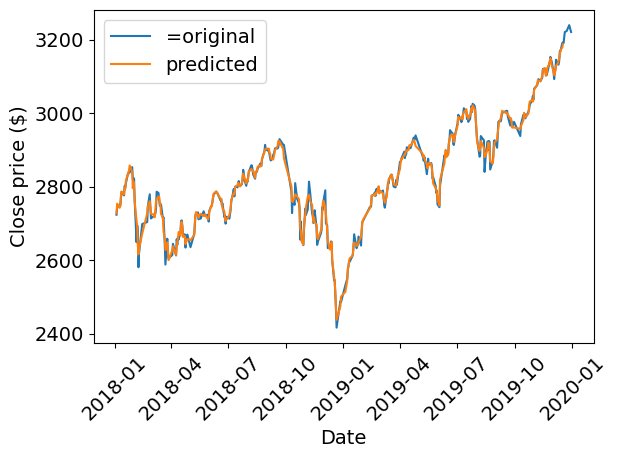

In [937]:
test_time_series = test.to_numpy()
prediction, compression_ratio = model.predict(test_time_series)

print('Compression ratio:', compression_ratio)
print('RMSRE:', rmsre(test_time_series, prediction))

plt.plot(test.index, test_time_series, label='=original', color='C0')
plt.plot(test.index, prediction, label='predicted', color='C1')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Close price ($)')
plt.legend()
plt.tight_layout()
plt.savefig('8_sparse_FTSRC_prediction_test.pdf')

### Results table

In [844]:
FTSRC_default_params_dict = {
  'dict_atoms_number': 20,
  'non_zero_coeff': 4,
  'sliding_window_size': 30,
  'sliding_window_stride': 10,
}

FTSRC_params_dict = {
  'dict_atoms_number': [10, 20, 50],
  'non_zero_coeff': [2,4,6,8],
  'sliding_window_size': [30, 60, 120],
  'sliding_window_stride': [5, 10, 20],
}


FTSRC_results = pd.DataFrame(
  columns=[
      'ticker',
      'dataset_type', 
      'dict_atoms_number', 
      'non_zero_coeff', 
      'sliding_window_size', 
      'sliding_window_stride', 
      'compression_ratio', 
      'price_rmsre', 
  ],
)

# Varing one parameter at a time and keeping the others to default
iterable = tqdm(FTSRC_params_dict.items())
for param_name, param_values in iterable:
    for param_value in param_values:
        
        # experiment parameters
        params = FTSRC_default_params_dict.copy()
        params[param_name] = param_value

        # load the model
        model = FinancialTimeSeriesSparseModel(
            n_components=params['dict_atoms_number'],
            n_nonzero_coefs=params['non_zero_coeff'],
            window_size=params['sliding_window_size'],
            stride=params['sliding_window_stride'],
            max_iter=100
        )

        # itterate over dataset indexes
        for stock_index in prices.columns:
            iterable.set_description(f'{param_name}: {param_value} - {stock_index}')  
            train, test = train_price[stock_index], test_price[stock_index]

            # fit transform and predict
            embds = model.fit(train.values.squeeze())
            prediction, train_compression_ratio = model.predict(train.values.squeeze())
            train_price_rmsre = rmsre(train.values.squeeze(), prediction)
            

            # transform data on the test set
            prediction, test_compression_ratio = model.predict(test.values.squeeze())
            test_price_rmsre = rmsre(test.values.squeeze(), prediction)

            # add the results to the dataframe
            FTSRC_results = pd.concat([
                FTSRC_results,
                pd.DataFrame(
                    [[
                        stock_index,
                        'train', 
                        params['dict_atoms_number'],
                        params['non_zero_coeff'],
                        params['sliding_window_size'],
                        params['sliding_window_stride'],
                        train_compression_ratio, 
                        train_price_rmsre
                    ]],
                    columns=FTSRC_results.columns
                ),
                pd.DataFrame(
                    [[
                        stock_index,
                        'test', 
                        params['dict_atoms_number'],
                        params['non_zero_coeff'],
                        params['sliding_window_size'],
                        params['sliding_window_stride'],
                        test_compression_ratio, 
                        test_price_rmsre
                    ]],
                    columns=FTSRC_results.columns
                )
            ])

dict_atoms_number: 10 - S&P 500:   0%|          | 0/4 [00:00<?, ?it/s]

[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

dict_atoms_number: 10 - Dow Jones:   0%|          | 0/4 [00:05<?, ?it/s]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

dict_atoms_number: 10 - Nasdaq 100:   0%|          | 0/4 [00:12<?, ?it/s]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

dict_atoms_number: 10 - FTSE 100:   0%|          | 0/4 [00:17<?, ?it/s]  


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

dict_atoms_number: 10 - DAX:   0%|          | 0/4 [00:23<?, ?it/s]     


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

dict_atoms_number: 10 - CAC 40:   0%|          | 0/4 [00:29<?, ?it/s]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

dict_atoms_number: 10 - Nikkei 225:   0%|          | 0/4 [00:35<?, ?it/s]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

dict_atoms_number: 10 - Hang Seng:   0%|          | 0/4 [00:41<?, ?it/s] 


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

dict_atoms_number: 10 - Shanghai Composite:   0%|          | 0/4 [00:47<?, ?it/s]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

dict_atoms_number: 10 - BSE Sensex:   0%|          | 0/4 [00:53<?, ?it/s]        


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

dict_atoms_number: 10 - ASX 200:   0%|          | 0/4 [00:59<?, ?it/s]   


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

dict_atoms_number: 10 - TSX Composite:   0%|          | 0/4 [01:06<?, ?it/s]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

dict_atoms_number: 10 - KOSPI:   0%|          | 0/4 [01:12<?, ?it/s]        


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

dict_atoms_number: 10 - Straits Times:   0%|          | 0/4 [01:18<?, ?it/s]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

dict_atoms_number: 20 - S&P 500:   0%|          | 0/4 [01:24<?, ?it/s]      


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

dict_atoms_number: 20 - Dow Jones:   0%|          | 0/4 [01:34<?, ?it/s]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

dict_atoms_number: 20 - Nasdaq 100:   0%|          | 0/4 [01:46<?, ?it/s]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

dict_atoms_number: 20 - FTSE 100:   0%|          | 0/4 [01:57<?, ?it/s]  


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

dict_atoms_number: 20 - DAX:   0%|          | 0/4 [02:08<?, ?it/s]     


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

dict_atoms_number: 20 - CAC 40:   0%|          | 0/4 [02:20<?, ?it/s]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

dict_atoms_number: 20 - Nikkei 225:   0%|          | 0/4 [02:30<?, ?it/s]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

dict_atoms_number: 20 - Hang Seng:   0%|          | 0/4 [02:42<?, ?it/s] 


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

dict_atoms_number: 20 - Shanghai Composite:   0%|          | 0/4 [02:53<?, ?it/s]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

dict_atoms_number: 20 - BSE Sensex:   0%|          | 0/4 [03:04<?, ?it/s]        


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

dict_atoms_number: 20 - ASX 200:   0%|          | 0/4 [03:15<?, ?it/s]   


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

dict_atoms_number: 20 - TSX Composite:   0%|          | 0/4 [03:26<?, ?it/s]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

dict_atoms_number: 20 - KOSPI:   0%|          | 0/4 [03:38<?, ?it/s]        


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................
[*] Transforming the segmented data into sparse codes...


dict_atoms_number: 20 - Straits Times:   0%|          | 0/4 [03:48<?, ?it/s]

[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

dict_atoms_number: 50 - S&P 500:   0%|          | 0/4 [03:59<?, ?it/s]      


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] .20 unused atoms resampled.
...................................................................................................
[*] Transforming the segmented data into sparse codes...


dict_atoms_number: 50 - Dow Jones:   0%|          | 0/4 [04:18<?, ?it/s]

[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] .20 unused atoms resampled.
...................................................................................................

dict_atoms_number: 50 - Nasdaq 100:   0%|          | 0/4 [04:39<?, ?it/s]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] .20 unused atoms resampled.
...................................................................................................
[*] Transforming the segmented data into sparse codes...


dict_atoms_number: 50 - FTSE 100:   0%|          | 0/4 [05:00<?, ?it/s]  

[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] .20 unused atoms resampled.
...................................................................................................

dict_atoms_number: 50 - DAX:   0%|          | 0/4 [05:21<?, ?it/s]     


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] .20 unused atoms resampled.
.1 unused atoms resampled.
..................................................................................................

dict_atoms_number: 50 - CAC 40:   0%|          | 0/4 [05:43<?, ?it/s]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] .20 unused atoms resampled.
.1 unused atoms resampled.
..................................................................................................

dict_atoms_number: 50 - Nikkei 225:   0%|          | 0/4 [06:05<?, ?it/s]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] .20 unused atoms resampled.
...................................................................................................

dict_atoms_number: 50 - Hang Seng:   0%|          | 0/4 [06:27<?, ?it/s] 


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] .20 unused atoms resampled.
...................................................................................................

dict_atoms_number: 50 - Shanghai Composite:   0%|          | 0/4 [06:49<?, ?it/s]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] .20 unused atoms resampled.
...................................................................................................
[*] Transforming the segmented data into sparse codes...


dict_atoms_number: 50 - BSE Sensex:   0%|          | 0/4 [07:08<?, ?it/s]        

[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] .20 unused atoms resampled.
...................................................................................................

dict_atoms_number: 50 - ASX 200:   0%|          | 0/4 [07:30<?, ?it/s]   


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] .20 unused atoms resampled.
...................................................................................................

dict_atoms_number: 50 - TSX Composite:   0%|          | 0/4 [07:51<?, ?it/s]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] .20 unused atoms resampled.
.1 unused atoms resampled.
..................................................................................................

dict_atoms_number: 50 - KOSPI:   0%|          | 0/4 [08:13<?, ?it/s]        


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] .20 unused atoms resampled.
...................................................................................................
[*] Transforming the segmented data into sparse codes...


dict_atoms_number: 50 - Straits Times:   0%|          | 0/4 [08:33<?, ?it/s]

[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] .20 unused atoms resampled.
...................................................................................................
[*] Transforming the segmented data into sparse codes...


non_zero_coeff: 2 - S&P 500:  25%|██▌       | 1/4 [08:53<26:40, 533.42s/it]          

[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................
[*] Transforming the segmented data into sparse codes...


non_zero_coeff: 2 - Dow Jones:  25%|██▌       | 1/4 [09:03<26:40, 533.42s/it]

[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 2 - Nasdaq 100:  25%|██▌       | 1/4 [09:14<26:40, 533.42s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 2 - FTSE 100:  25%|██▌       | 1/4 [09:25<26:40, 533.42s/it]  


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 2 - DAX:  25%|██▌       | 1/4 [09:36<26:40, 533.42s/it]     


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 2 - CAC 40:  25%|██▌       | 1/4 [09:47<26:40, 533.42s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 2 - Nikkei 225:  25%|██▌       | 1/4 [09:58<26:40, 533.42s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 2 - Hang Seng:  25%|██▌       | 1/4 [10:10<26:40, 533.42s/it] 


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 2 - Shanghai Composite:  25%|██▌       | 1/4 [10:21<26:40, 533.42s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 2 - BSE Sensex:  25%|██▌       | 1/4 [10:32<26:40, 533.42s/it]        


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 2 - ASX 200:  25%|██▌       | 1/4 [10:43<26:40, 533.42s/it]   


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 2 - TSX Composite:  25%|██▌       | 1/4 [10:54<26:40, 533.42s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 2 - KOSPI:  25%|██▌       | 1/4 [11:05<26:40, 533.42s/it]        


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................
[*] Transforming the segmented data into sparse codes...


non_zero_coeff: 2 - Straits Times:  25%|██▌       | 1/4 [11:16<26:40, 533.42s/it]

[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 4 - S&P 500:  25%|██▌       | 1/4 [11:27<26:40, 533.42s/it]      


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 4 - Dow Jones:  25%|██▌       | 1/4 [11:37<26:40, 533.42s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 4 - Nasdaq 100:  25%|██▌       | 1/4 [11:48<26:40, 533.42s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 4 - FTSE 100:  25%|██▌       | 1/4 [11:59<26:40, 533.42s/it]  


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 4 - DAX:  25%|██▌       | 1/4 [12:10<26:40, 533.42s/it]     


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 4 - CAC 40:  25%|██▌       | 1/4 [12:21<26:40, 533.42s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 4 - Nikkei 225:  25%|██▌       | 1/4 [12:32<26:40, 533.42s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 4 - Hang Seng:  25%|██▌       | 1/4 [12:44<26:40, 533.42s/it] 


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 4 - Shanghai Composite:  25%|██▌       | 1/4 [12:55<26:40, 533.42s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 4 - BSE Sensex:  25%|██▌       | 1/4 [13:06<26:40, 533.42s/it]        


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 4 - ASX 200:  25%|██▌       | 1/4 [13:17<26:40, 533.42s/it]   


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 4 - TSX Composite:  25%|██▌       | 1/4 [13:28<26:40, 533.42s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 4 - KOSPI:  25%|██▌       | 1/4 [13:39<26:40, 533.42s/it]        


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................
[*] Transforming the segmented data into sparse codes...


non_zero_coeff: 4 - Straits Times:  25%|██▌       | 1/4 [13:50<26:40, 533.42s/it]

[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 6 - S&P 500:  25%|██▌       | 1/4 [14:01<26:40, 533.42s/it]      


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 6 - Dow Jones:  25%|██▌       | 1/4 [14:11<26:40, 533.42s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 6 - Nasdaq 100:  25%|██▌       | 1/4 [14:22<26:40, 533.42s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 6 - FTSE 100:  25%|██▌       | 1/4 [14:33<26:40, 533.42s/it]  


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 6 - DAX:  25%|██▌       | 1/4 [14:45<26:40, 533.42s/it]     


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 6 - CAC 40:  25%|██▌       | 1/4 [14:56<26:40, 533.42s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 6 - Nikkei 225:  25%|██▌       | 1/4 [15:07<26:40, 533.42s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 6 - Hang Seng:  25%|██▌       | 1/4 [15:18<26:40, 533.42s/it] 


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 6 - Shanghai Composite:  25%|██▌       | 1/4 [15:30<26:40, 533.42s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 6 - BSE Sensex:  25%|██▌       | 1/4 [15:41<26:40, 533.42s/it]        


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 6 - ASX 200:  25%|██▌       | 1/4 [15:52<26:40, 533.42s/it]   


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 6 - TSX Composite:  25%|██▌       | 1/4 [16:03<26:40, 533.42s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 6 - KOSPI:  25%|██▌       | 1/4 [16:14<26:40, 533.42s/it]        


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................
[*] Transforming the segmented data into sparse codes...

non_zero_coeff: 6 - Straits Times:  25%|██▌       | 1/4 [16:25<26:40, 533.42s/it]


[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 8 - S&P 500:  25%|██▌       | 1/4 [16:36<26:40, 533.42s/it]      


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 8 - Dow Jones:  25%|██▌       | 1/4 [16:46<26:40, 533.42s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 8 - Nasdaq 100:  25%|██▌       | 1/4 [16:57<26:40, 533.42s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 8 - FTSE 100:  25%|██▌       | 1/4 [17:08<26:40, 533.42s/it]  


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 8 - DAX:  25%|██▌       | 1/4 [17:20<26:40, 533.42s/it]     


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 8 - CAC 40:  25%|██▌       | 1/4 [17:31<26:40, 533.42s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 8 - Nikkei 225:  25%|██▌       | 1/4 [17:42<26:40, 533.42s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 8 - Hang Seng:  25%|██▌       | 1/4 [17:54<26:40, 533.42s/it] 


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 8 - Shanghai Composite:  25%|██▌       | 1/4 [18:05<26:40, 533.42s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 8 - BSE Sensex:  25%|██▌       | 1/4 [18:16<26:40, 533.42s/it]        


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 8 - ASX 200:  25%|██▌       | 1/4 [18:27<26:40, 533.42s/it]   


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 8 - TSX Composite:  25%|██▌       | 1/4 [18:38<26:40, 533.42s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

non_zero_coeff: 8 - KOSPI:  25%|██▌       | 1/4 [18:50<26:40, 533.42s/it]        


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................
[*] Transforming the segmented data into sparse codes...

non_zero_coeff: 8 - Straits Times:  25%|██▌       | 1/4 [19:00<26:40, 533.42s/it]


[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_size: 30 - S&P 500:  50%|█████     | 2/4 [19:11<19:26, 583.07s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................
[*] Transforming the segmented data into sparse codes...


sliding_window_size: 30 - Dow Jones:  50%|█████     | 2/4 [19:21<19:26, 583.07s/it]

[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_size: 30 - Nasdaq 100:  50%|█████     | 2/4 [19:32<19:26, 583.07s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_size: 30 - FTSE 100:  50%|█████     | 2/4 [19:43<19:26, 583.07s/it]  


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_size: 30 - DAX:  50%|█████     | 2/4 [19:54<19:26, 583.07s/it]     


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_size: 30 - CAC 40:  50%|█████     | 2/4 [20:06<19:26, 583.07s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_size: 30 - Nikkei 225:  50%|█████     | 2/4 [20:17<19:26, 583.07s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_size: 30 - Hang Seng:  50%|█████     | 2/4 [20:28<19:26, 583.07s/it] 


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_size: 30 - Shanghai Composite:  50%|█████     | 2/4 [20:40<19:26, 583.07s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_size: 30 - BSE Sensex:  50%|█████     | 2/4 [20:51<19:26, 583.07s/it]        


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_size: 30 - ASX 200:  50%|█████     | 2/4 [21:02<19:26, 583.07s/it]   


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_size: 30 - TSX Composite:  50%|█████     | 2/4 [21:13<19:26, 583.07s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_size: 30 - KOSPI:  50%|█████     | 2/4 [21:25<19:26, 583.07s/it]        


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................
[*] Transforming the segmented data into sparse codes...


sliding_window_size: 30 - Straits Times:  50%|█████     | 2/4 [21:35<19:26, 583.07s/it]

[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_size: 60 - S&P 500:  50%|█████     | 2/4 [21:46<19:26, 583.07s/it]      


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................
[*] Transforming the segmented data into sparse codes...


sliding_window_size: 60 - Dow Jones:  50%|█████     | 2/4 [21:56<19:26, 583.07s/it]

[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_size: 60 - Nasdaq 100:  50%|█████     | 2/4 [22:08<19:26, 583.07s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_size: 60 - FTSE 100:  50%|█████     | 2/4 [22:19<19:26, 583.07s/it]  


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_size: 60 - DAX:  50%|█████     | 2/4 [22:30<19:26, 583.07s/it]     


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_size: 60 - CAC 40:  50%|█████     | 2/4 [22:41<19:26, 583.07s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_size: 60 - Nikkei 225:  50%|█████     | 2/4 [22:53<19:26, 583.07s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_size: 60 - Hang Seng:  50%|█████     | 2/4 [23:04<19:26, 583.07s/it] 


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_size: 60 - Shanghai Composite:  50%|█████     | 2/4 [23:16<19:26, 583.07s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_size: 60 - BSE Sensex:  50%|█████     | 2/4 [23:27<19:26, 583.07s/it]        


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_size: 60 - ASX 200:  50%|█████     | 2/4 [23:38<19:26, 583.07s/it]   


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_size: 60 - TSX Composite:  50%|█████     | 2/4 [23:49<19:26, 583.07s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_size: 60 - KOSPI:  50%|█████     | 2/4 [24:01<19:26, 583.07s/it]        


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_size: 60 - Straits Times:  50%|█████     | 2/4 [24:12<19:26, 583.07s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_size: 120 - S&P 500:  50%|█████     | 2/4 [24:23<19:26, 583.07s/it]     


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_size: 120 - Dow Jones:  50%|█████     | 2/4 [24:39<19:26, 583.07s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_size: 120 - Nasdaq 100:  50%|█████     | 2/4 [24:55<19:26, 583.07s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_size: 120 - FTSE 100:  50%|█████     | 2/4 [25:12<19:26, 583.07s/it]  


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................
[*] Transforming the segmented data into sparse codes...


sliding_window_size: 120 - DAX:  50%|█████     | 2/4 [25:28<19:26, 583.07s/it]     

[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................
[*] Transforming the segmented data into sparse codes...


sliding_window_size: 120 - CAC 40:  50%|█████     | 2/4 [25:45<19:26, 583.07s/it]

[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_size: 120 - Nikkei 225:  50%|█████     | 2/4 [26:01<19:26, 583.07s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_size: 120 - Hang Seng:  50%|█████     | 2/4 [26:18<19:26, 583.07s/it] 


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_size: 120 - Shanghai Composite:  50%|█████     | 2/4 [26:34<19:26, 583.07s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................
[*] Transforming the segmented data into sparse codes...

sliding_window_size: 120 - BSE Sensex:  50%|█████     | 2/4 [26:51<19:26, 583.07s/it]        


[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_size: 120 - ASX 200:  50%|█████     | 2/4 [27:08<19:26, 583.07s/it]   


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_size: 120 - TSX Composite:  50%|█████     | 2/4 [27:24<19:26, 583.07s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................
[*] Transforming the segmented data into sparse codes...


sliding_window_size: 120 - KOSPI:  50%|█████     | 2/4 [27:41<19:26, 583.07s/it]        

[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_size: 120 - Straits Times:  50%|█████     | 2/4 [27:57<19:26, 583.07s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_stride: 5 - S&P 500:  75%|███████▌  | 3/4 [28:14<09:24, 564.84s/it]      


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................
[*] Transforming the segmented data into sparse codes...


sliding_window_stride: 5 - Dow Jones:  75%|███████▌  | 3/4 [28:35<09:24, 564.84s/it]

[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_stride: 5 - Nasdaq 100:  75%|███████▌  | 3/4 [28:57<09:24, 564.84s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_stride: 5 - FTSE 100:  75%|███████▌  | 3/4 [29:19<09:24, 564.84s/it]  


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_stride: 5 - DAX:  75%|███████▌  | 3/4 [29:41<09:24, 564.84s/it]     


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_stride: 5 - CAC 40:  75%|███████▌  | 3/4 [30:03<09:24, 564.84s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_stride: 5 - Nikkei 225:  75%|███████▌  | 3/4 [30:25<09:24, 564.84s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_stride: 5 - Hang Seng:  75%|███████▌  | 3/4 [30:48<09:24, 564.84s/it] 


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_stride: 5 - Shanghai Composite:  75%|███████▌  | 3/4 [31:10<09:24, 564.84s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_stride: 5 - BSE Sensex:  75%|███████▌  | 3/4 [31:32<09:24, 564.84s/it]        


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_stride: 5 - ASX 200:  75%|███████▌  | 3/4 [31:54<09:24, 564.84s/it]   


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_stride: 5 - TSX Composite:  75%|███████▌  | 3/4 [32:16<09:24, 564.84s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_stride: 5 - KOSPI:  75%|███████▌  | 3/4 [32:39<09:24, 564.84s/it]        


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_stride: 5 - Straits Times:  75%|███████▌  | 3/4 [33:00<09:24, 564.84s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_stride: 10 - S&P 500:  75%|███████▌  | 3/4 [33:21<09:24, 564.84s/it]     


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_stride: 10 - Dow Jones:  75%|███████▌  | 3/4 [33:31<09:24, 564.84s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_stride: 10 - Nasdaq 100:  75%|███████▌  | 3/4 [33:42<09:24, 564.84s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_stride: 10 - FTSE 100:  75%|███████▌  | 3/4 [33:53<09:24, 564.84s/it]  


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_stride: 10 - DAX:  75%|███████▌  | 3/4 [34:04<09:24, 564.84s/it]     


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_stride: 10 - CAC 40:  75%|███████▌  | 3/4 [34:16<09:24, 564.84s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_stride: 10 - Nikkei 225:  75%|███████▌  | 3/4 [34:27<09:24, 564.84s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_stride: 10 - Hang Seng:  75%|███████▌  | 3/4 [34:38<09:24, 564.84s/it] 


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_stride: 10 - Shanghai Composite:  75%|███████▌  | 3/4 [34:49<09:24, 564.84s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_stride: 10 - BSE Sensex:  75%|███████▌  | 3/4 [35:00<09:24, 564.84s/it]        


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_stride: 10 - ASX 200:  75%|███████▌  | 3/4 [35:11<09:24, 564.84s/it]   


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_stride: 10 - TSX Composite:  75%|███████▌  | 3/4 [35:22<09:24, 564.84s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_stride: 10 - KOSPI:  75%|███████▌  | 3/4 [35:34<09:24, 564.84s/it]        


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................
[*] Transforming the segmented data into sparse codes...


sliding_window_stride: 10 - Straits Times:  75%|███████▌  | 3/4 [35:44<09:24, 564.84s/it]

[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_stride: 20 - S&P 500:  75%|███████▌  | 3/4 [35:55<09:24, 564.84s/it]      


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................
[*] Transforming the segmented data into sparse codes...


sliding_window_stride: 20 - Dow Jones:  75%|███████▌  | 3/4 [36:00<09:24, 564.84s/it]

[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_stride: 20 - Nasdaq 100:  75%|███████▌  | 3/4 [36:05<09:24, 564.84s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_stride: 20 - FTSE 100:  75%|███████▌  | 3/4 [36:11<09:24, 564.84s/it]  


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_stride: 20 - DAX:  75%|███████▌  | 3/4 [36:16<09:24, 564.84s/it]     


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_stride: 20 - CAC 40:  75%|███████▌  | 3/4 [36:22<09:24, 564.84s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_stride: 20 - Nikkei 225:  75%|███████▌  | 3/4 [36:28<09:24, 564.84s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_stride: 20 - Hang Seng:  75%|███████▌  | 3/4 [36:33<09:24, 564.84s/it] 


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_stride: 20 - Shanghai Composite:  75%|███████▌  | 3/4 [36:39<09:24, 564.84s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................
[*] Transforming the segmented data into sparse codes...


sliding_window_stride: 20 - BSE Sensex:  75%|███████▌  | 3/4 [36:44<09:24, 564.84s/it]        

[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_stride: 20 - ASX 200:  75%|███████▌  | 3/4 [36:50<09:24, 564.84s/it]   


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_stride: 20 - TSX Composite:  75%|███████▌  | 3/4 [36:56<09:24, 564.84s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_stride: 20 - KOSPI:  75%|███████▌  | 3/4 [37:01<09:24, 564.84s/it]        


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................

sliding_window_stride: 20 - Straits Times:  75%|███████▌  | 3/4 [37:06<09:24, 564.84s/it]


[*] Transforming the segmented data into sparse codes...
[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................
[*] Transforming the segmented data into sparse codes...


sliding_window_stride: 20 - Straits Times: 100%|██████████| 4/4 [37:12<00:00, 558.04s/it]


In [860]:
df = FTSRC_results.sort_values(by=['dataset_type'])
df = df.groupby(['dataset_type', 'dict_atoms_number', 'non_zero_coeff', 'sliding_window_size', 'sliding_window_stride']).mean().unstack('dataset_type').swaplevel(axis=1).sort_index(axis=1).reset_index()


# varing one parameter at a time and keeping the others to default
df = df[
  (df['dict_atoms_number'] == FTSRC_default_params_dict['dict_atoms_number'])
  & (df['non_zero_coeff'] == FTSRC_default_params_dict['non_zero_coeff'])
  & (df['sliding_window_size'] == FTSRC_default_params_dict['sliding_window_size'])
  # & (df['sliding_window_stride'] == FTSRC_default_params_dict['sliding_window_stride'])
].set_index('sliding_window_stride').drop(columns=[
  'dict_atoms_number', 
  'non_zero_coeff', 
  'sliding_window_size',
  # 'sliding_window_stride', 
    ]
)
df.columns.names = [None, None]
print(df.round(5).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} & \multicolumn{2}{l}{test} & \multicolumn{2}{l}{train} \\
{} & compression\_ratio & price\_rmsre & compression\_ratio & price\_rmsre \\
sliding\_window\_stride &                   &             &                   &             \\
\midrule
5                     &               7.5 &     0.00689 &               7.5 &     0.00736 \\
10                    &               7.5 &     0.00736 &               7.5 &     0.00738 \\
20                    &               7.5 &     0.00845 &               7.5 &     0.00769 \\
\bottomrule
\end{tabular}



/var/folders/k1/n25_cgpj17b12lgf2qvp_t_h0000gn/T/ipykernel_20347/1150163443.py:6: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df = df[
/var/folders/k1/n25_cgpj17b12lgf2qvp_t_h0000gn/T/ipykernel_20347/1150163443.py:19: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.round(5).to_latex())


In [ ]:
df = meSAX_results.sort_values(by=['dataset_type'])
df = df.groupby(['dataset_type', 'alphabet_size', 'rolling_window_size', 'rolling_window_stride', 'paa_window_size', 'fitting_method', 'reconstruction_method']).mean().unstack('dataset_type').swaplevel(axis=1).sort_index(axis=1).reset_index()

# varing one parameter at a time and keeping the others to default
df = df[
  (df['alphabet_size'] == meSAX_default_params_dict['alphabet_size'])
  & (df['rolling_window_size'] == meSAX_default_params_dict['rolling_window_size'])
  & (df['rolling_window_stride'] == meSAX_default_params_dict['rolling_window_stride'])
  & (df['paa_window_size'] == meSAX_default_params_dict['paa_window_size'])
  & (df['fitting_method'] == meSAX_default_params_dict['fitting_method'])
  # & (df['reconstruction_method'] == meSAX_default_params_dict['reconstruction_method'])
].set_index('reconstruction_method').drop(columns=[
  'alphabet_size', 
  'rolling_window_size', 
  'rolling_window_stride',
    'paa_window_size', 
    'fitting_method', 
    # 'reconstruction_method'
    ]
)
df.columns.names = [None, None]
print(df.to_latex(float_format='%.4f'))